In [1]:
# Libraries and modules for the sentiment analysis
import pandas as pd
from textblob import TextBlob
from wordcloud import WordCloud
import numpy as np
import matplotlib.pyplot as plt
import re

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import joblib
import pickle

import nltk

nltk.download('stopwords')

from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
ps = PorterStemmer()

all_stopwords = stopwords.words('english')
all_stopwords.remove('not')
plt.style.use('fivethirtyeight')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kings\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
piggy_data = pd.read_csv('piggyvest_new.csv')

In [3]:
# This Function is to clean the dataset and remove the noise
def cleanData(data):
  data = re.sub(r'@[A-Za-z0-9_]+', '', data) # this will remove the @ mentions
  data = re.sub(r'#', '', data) # this will remove the # symbols
  data = re.sub(r'https?:\/\/\s+', '', data) # This will remove the hyperlink
  data = re.sub(r'\n+', '', data) # This will removes all mention of \n
  data = re.sub(r'_', '', data) # This will remove _
  data = re.sub(r'[0-9]', '', data) # This will remove numbers
  data = data.lower()
  data = data.split()
  data = [ps.stem(word) for word in data if not word in set(all_stopwords)]
  data = ' '.join(data)
  return data

In [4]:
piggy_data['review'] = piggy_data['content'].apply(cleanData)

In [5]:
# Create a function to get the subjectivity. This tells the subjectivity of the users
def reviewSubjectivity(data):
  return TextBlob(data).sentiment.subjectivity

In [6]:
# New column for the subjectivity
piggy_data['subjectivity'] = piggy_data['review'].apply(reviewSubjectivity)

In [7]:
# Create a function that tells the polarity of the review
def reviewPolarity(data):
  return TextBlob(data).sentiment.polarity

In [8]:
# New column for the polarity
piggy_data['polarity'] = piggy_data['review'].apply(reviewPolarity)

In [9]:
piggy_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21632 entries, 0 to 21631
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   reviewId              21632 non-null  object 
 1   userName              21632 non-null  object 
 2   userImage             21632 non-null  object 
 3   content               21632 non-null  object 
 4   score                 21632 non-null  int64  
 5   thumbsUpCount         21632 non-null  int64  
 6   reviewCreatedVersion  18277 non-null  object 
 7   at                    21632 non-null  object 
 8   replyContent          292 non-null    object 
 9   repliedAt             292 non-null    object 
 10  review                21632 non-null  object 
 11  subjectivity          21632 non-null  float64
 12  polarity              21632 non-null  float64
dtypes: float64(2), int64(2), object(9)
memory usage: 2.1+ MB


In [10]:
#convert the 'at' column to datetime this will help sort the reviews by date and filter only the most recent
piggy_data['review_date']= pd.to_datetime(piggy_data['at'])

In [11]:
piggy_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21632 entries, 0 to 21631
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   reviewId              21632 non-null  object        
 1   userName              21632 non-null  object        
 2   userImage             21632 non-null  object        
 3   content               21632 non-null  object        
 4   score                 21632 non-null  int64         
 5   thumbsUpCount         21632 non-null  int64         
 6   reviewCreatedVersion  18277 non-null  object        
 7   at                    21632 non-null  object        
 8   replyContent          292 non-null    object        
 9   repliedAt             292 non-null    object        
 10  review                21632 non-null  object        
 11  subjectivity          21632 non-null  float64       
 12  polarity              21632 non-null  float64       
 13  review_date     

In [12]:
piggy_data = piggy_data.sort_values(by=['review_date'], ascending=False)

In [13]:
#from last scraping we want to target reviews that are 8days old at most
piggy_data = piggy_data[piggy_data['review_date'] >= '2022-11-21 00:00:00']

In [14]:
piggy_data.shape

(23, 14)

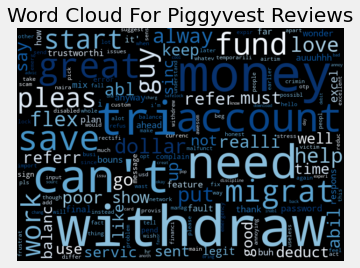

In [15]:
# Create a word cloud for the tweet which will visualize the frequently used words
alltexts = ' '.join([word for word in piggy_data['review']])
wordcloud = WordCloud(width = 700, height = 500, random_state = 21, max_font_size = 120, colormap='Blues', stopwords = ['piggyvest', 'piggy', 'vest', 'app', 'https', 'http']).generate(alltexts)
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.title('Word Cloud For Piggyvest Reviews')
plt.show()

In [16]:
# Create a function to compute the negative, neutral and politive analysis
def polarityAnalysis(score):
  if score < 0:
    return 'Negative'
  elif score == 0:
    return 'Neutral'
  else:
    return 'Positive'

In [17]:
# Create new column that checks the analysis of the polarity
piggy_data['Analysis'] = piggy_data['polarity'].apply(polarityAnalysis)

In [18]:
# Create a function to compute the label column. Every polarity greater than 0 is satisfactory while rating less than or equal to 0 is not satifactory
def ratingPolarity(rating):
  if rating > 0:
    return 1
  else:
    return 0

In [19]:
piggy_data['binaryrating'] = piggy_data['polarity'].apply(ratingPolarity)

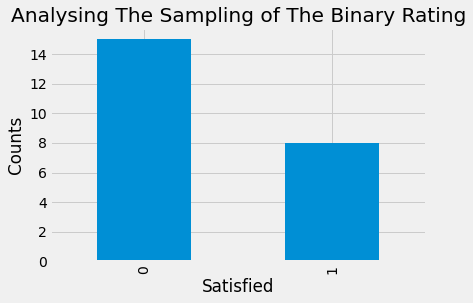

In [20]:
piggy_data['binaryrating'].value_counts()

plt.title('Analysing The Sampling of The Binary Rating')
plt.xlabel('Satisfied')
plt.ylabel('Counts')
piggy_data['binaryrating'].value_counts().plot(kind = 'bar')
plt.show()

In [21]:
#Drop all column that are not currectly relevant to the problem we want to solve
piggy_data.drop(["repliedAt", "replyContent", "reviewCreatedVersion", "userImage" ], axis = 1, inplace=True)

## Data Transofrmation

In [22]:
# Import the bog of words saved during the development of the model
cv_file = 'BagOfWordSentiment_Model.pkl'
cv = pickle.load(open(cv_file, "rb"))

In [23]:
#Transform the reviews usinf the bag of words count vectorizer
x_fresh_reviews = cv.transform(piggy_data['review']).toarray()
x_fresh_reviews.shape

(23, 1420)

## Naive Bayes Model For Prediction

In [24]:
# Load the our model to help predict the new reviews
import joblib
classifier = joblib.load('Classifier_Sentiment GNB Model')

In [25]:
# Run the prediction of the prediction
y_pred1 = classifier.predict(x_fresh_reviews)

In [26]:
print(y_pred1)

[1 0 0 0 0 0 0 0 1 0 1 1 1 0 0 0 1 0 0 1 0 0 0]


## Using Support Vector Classifier Model For Prediction

In [27]:
svc = joblib.load('Classifier_Sentiment SVC Model')

In [28]:
# Run the prediction of the prediction with support vector classifier model
y_pred = svc.predict(x_fresh_reviews)

In [29]:
#Add the predicted reviews to the data frame
piggy_data['naive_bayes_predicted_label'] = y_pred1.tolist()
piggy_data['svc_predicted_label'] = y_pred.tolist()
piggy_data.head(20)

,reviewId,userName,content,score,thumbsUpCount,at,review,subjectivity,polarity,review_date,Analysis,binaryrating,naive_bayes_predicted_label,svc_predicted_label
16346,2fed7b73-5442-4c43-b92c-1e4f47075064,Daniel Chibuzor,Great App,5,0,2022-11-30 06:43:43,great app,0.750000,0.800000,2022-11-30 06:43:43,Positive,1,1,1
16629,ec67988a-d382-4489-9cf6-059383570f4d,Agboju Daniel,100% legit this app has really save me,5,0,2022-11-30 05:13:55,% legit app realli save,0.000000,0.000000,2022-11-30 05:13:55,Neutral,0,0,0
17123,5dc9a568-30fa-4db4-a045-424ae6d5bf54,Odion Elvis,Excellent and trustworthy,5,0,2022-11-29 17:51:24,excel trustworthi,0.000000,0.000000,2022-11-29 17:51:24,Neutral,0,0,0
12694,570a336e-eb34-4e7e-8c50-2217117440c8,Damilare dare,Poor can't migrate my referer bouns...how do I...,1,0,2022-11-29 05:15:15,poor can't migrat refer bouns...how go,0.600000,-0.400000,2022-11-29 05:15:15,Negative,0,0,0
8635,ae2de4cb-3965-44e8-8f22-0c4eab02602c,Adebola Morenikeji,Auuuhhh...I finally was able to withdraw...it'...,5,0,2022-11-28 12:25:57,auuuhhh...i final abl withdraw...it' fault mix...,1.000000,0.000000,2022-11-28 12:25:57,Neutral,0,0,0
55,8feb899c-a14c-4628-8cd3-bf4a3e4a71e6,Ben Udemeh,"I must say the app has been wonderful so far, ...",4,1,2022-11-28 11:11:02,"must say app wonder far, abil respons fund pla...",0.512500,0.175000,2022-11-28 11:11:02,Positive,1,0,1
3125,7219de1c-bd1d-4f69-8c27-def21ec5ce00,MATHEW YEYE,Very poor network service and issues. Customer...,1,0,2022-11-28 08:32:02,poor network servic issues. custom servic wast...,0.600000,-0.400000,2022-11-28 08:32:02,Negative,0,0,0
114,b5a5d03e-9318-4671-96e9-f136c88e1fec,Fola Olalere,"Hello piggyvest, you guys have started malfunc...",2,0,2022-11-28 06:24:06,"hello piggyvest, guy start malfunct again, rec...",0.750000,-0.575000,2022-11-28 06:24:06,Negative,0,0,1
740,8889ca2c-c51c-438f-bee6-793784509b93,Blessing Nwoko,"I'm very pleased with this app, works very wel...",5,0,2022-11-27 23:36:36,"i'm pleas app, work well, possibl make provis ...",0.000000,0.000000,2022-11-27 23:36:36,Neutral,0,1,0
11111,29c4eab7-0b4a-4225-8b23-9a9590f370ae,cosmos izibili,Why can't i withdraw more than 2000 naira,3,0,2022-11-27 18:04:30,can't withdraw naira,0.000000,0.000000,2022-11-27 18:04:30,Neutral,0,0,0


In [31]:
piggy_data[['content', 'Analysis', 'binaryrating', 'naive_bayes_predicted_label', 'svc_predicted_label']]

,content,Analysis,binaryrating,naive_bayes_predicted_label,svc_predicted_label
16346,Great App,Positive,1,1,1
16629,100% legit this app has really save me,Neutral,0,0,0
17123,Excellent and trustworthy,Neutral,0,0,0
12694,Poor can't migrate my referer bouns...how do I...,Negative,0,0,0
8635,Auuuhhh...I finally was able to withdraw...it'...,Neutral,0,0,0
55,"I must say the app has been wonderful so far, ...",Positive,1,0,1
3125,Very poor network service and issues. Customer...,Negative,0,0,0
114,"Hello piggyvest, you guys have started malfunc...",Negative,0,0,1
740,"I'm very pleased with this app, works very wel...",Neutral,0,1,0
11111,Why can't i withdraw more than 2000 naira,Neutral,0,0,0


In [30]:
new_neg_pred = piggy_data[piggy_data['naive_bayes_predicted_label'] == 0]
new_neg_pred.to_csv('piggyvest_updated.csv', index = None)

## Email Automation For Decision Making

In [33]:
import os
import smtplib
import ssl
from email.message import EmailMessage

email_sender = 'dekings44@gmail.com'
email_password = 'ridlnspwomojasjn'
email_receiver = ['ihemere3@gmail.com', 'maryemanyo@gmail.com', 'carolineighodalo@gmail.com', 'salomekingsley33@gmail.com'] 


subject = 'This is the negative sentiment for the week'
body = ''' How about following up with this unhappy clients?
I think they are dissatisfied or unhappy client.
We don't want them to churn or be porched by our competitors
'''


em = EmailMessage()
em['From'] = email_sender
em['To'] = email_receiver
em['Subject'] = subject
em.set_content(body)

    
with open('piggyvest_updated.csv', 'rb') as f:
    file_data = f.read()
    file_name = f.name

em.add_attachment(file_data, maintype = 'application', subtype='octet-stream', filename = file_name)

context = ssl.create_default_context()

with smtplib.SMTP_SSL('smtp.gmail.com', 465, context=context) as smtp:

    smtp.login(email_sender, email_password)

    smtp.sendmail(email_sender, email_receiver, em.as_string())